# Discrimination des solutions de la surface de Pareto

### Imports

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
from scipy.interpolate import griddata

## Small dataset

### Import des données

In [2]:
with open("../solutions/small/solutions.json") as f:
    data = json.load(f)

In [3]:
results = []
for key1 in data:
    for key2 in data[key1]:
        results.append([int(key1), int(key2), data[key1][key2]])
results = np.array(results)
results_pd = pd.DataFrame({
    "Day": results[:, 0],
    "NbProject": results[:, 1],
    "Price": results[:, 2]
})
results_pd

,Day,NbProject,Price
0,5.0,5.0,65.0
1,5.0,4.0,65.0
2,5.0,3.0,65.0
3,5.0,2.0,65.0
4,5.0,1.0,59.0
5,4.0,5.0,65.0
6,4.0,4.0,65.0
7,4.0,3.0,65.0
8,4.0,2.0,65.0
9,4.0,1.0,59.0


### Visualisations

/var/folders/5q/nhw4d0ys1kqgclnb7dz1yphm0000gp/T/ipykernel_89478/2189225230.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


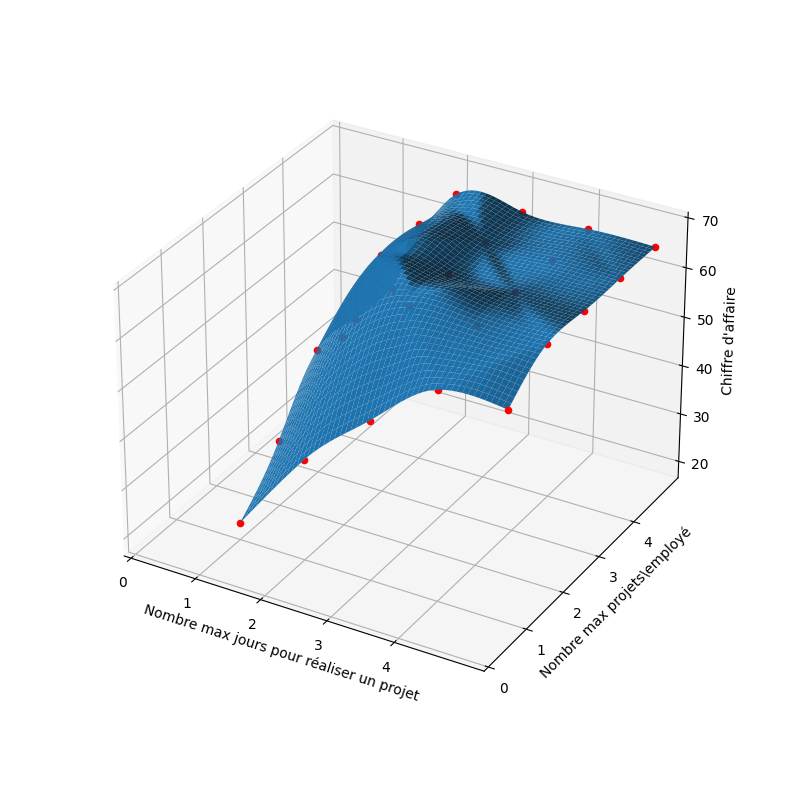

In [4]:
points = results

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))

X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

for point in results:
    xi, yi, zi = point
    ax.scatter(xi, yi, zi, c='r', marker='o')

ax.set_xlabel('Nombre max jours pour réaliser un projet')
ax.set_xticks(np.arange(int(max(x))))
ax.set_ylabel('Nombre max projets\\employé')
ax.set_yticks(np.arange(int(max(y))))
ax.set_zlabel('Chiffre d\'affaire')
ax.dist = 12
plt.show()


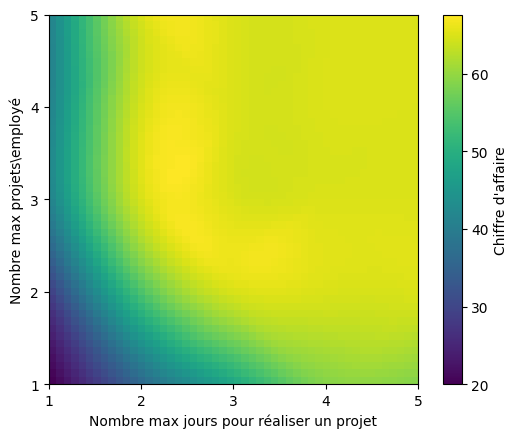

In [5]:
import numpy as np
import matplotlib.pyplot as plt

points = results
x = np.array([point[0] for point in points])
y = np.array([point[1] for point in points])
z = np.array([point[2] for point in points])
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Chiffre d\'affaire')
plt.xlabel('Nombre max jours pour réaliser un projet')
plt.xticks(np.arange(1, int(max(x) + 1)))
plt.ylabel('Nombre max projets\\employé')
plt.yticks(np.arange(1, int(max(y) + 1)))
plt.show()

### Catégorisation des solutions

In [6]:
# Implémentation Python
num_edt, dim = results.shape

m = Model("Preferences")
# W : Dict[int, Var]
W = {d: m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'w{d}') for d in range(dim)}

d_plus = []
d_moins = []
for j in range(num_edt):
    d_plus.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'd_plus_{j}'))
    d_moins.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'd_moins_{j}'))

# EdtDictLinExpr : Dict[int, LinExpr]
EdtDictLinExpr = {
    j: quicksum([W[i] * results[j][i] for i in range(dim)]) / max(results[j]) - d_plus[
        j] + d_moins[j] for j in range(num_edt)}

# Contraintes inacceptables
m.addConstr(EdtDictLinExpr[0] <= 1 / 3, name="C_1")
m.addConstr(EdtDictLinExpr[1] <= 1 / 3, name="C_2")
m.addConstr(EdtDictLinExpr[5] <= 1 / 3, name="C_3")
m.addConstr(EdtDictLinExpr[6] <= 1 / 3, name="C_4")

# Contraintes correctes
m.addConstr(EdtDictLinExpr[7] <= 2 / 3, name="C_5")
m.addConstr(EdtDictLinExpr[7] >= 1 / 3, name="C_6")
m.addConstr(EdtDictLinExpr[11] <= 2 / 3, name="C_7")
m.addConstr(EdtDictLinExpr[11] >= 1 / 3, name="C_8")

# Contraintes satisfaisantes
m.addConstr(EdtDictLinExpr[13] >= 2 / 3, name="C_9")
m.addConstr(EdtDictLinExpr[17] >= 2 / 3, name="C_10")

# Contrainte 4 : Normalisation
m.addConstr(quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0  # mode muet

# -- Mise à jour du modèle  --
m.update()

m.setObjective(quicksum(d_plus[j] + d_moins[j] for j in range(num_edt)), GRB.MAXIMIZE)

m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Infasible")
if m.status == GRB.UNBOUNDED:
    print("Unbounded")
if m.status == GRB.OPTIMAL:
    weights = [W[i].x for i in range(dim)]
    print("Optimal")
    print(weights)

scores = [EdtDictLinExpr[j].getValue() for j in range(num_edt)]
results_pd['score'] = scores
results_pd['status'] = results_pd['score'].apply(
    lambda x: 'Inacceptable' if x < 1 / 3 else (
        'Correcte' if x < 2 / 3 else 'Satisfaisante'))
results_pd

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-11
Optimal
[0.3523035230352294, 0.35230352303523144, 0.29539295392953924]


,Day,NbProject,Price,score,status
0,5.0,5.0,65.0,0.333333,Inacceptable
1,5.0,4.0,65.0,0.333333,Inacceptable
2,5.0,3.0,65.0,0.338753,Correcte
3,5.0,2.0,65.0,0.333333,Inacceptable
4,5.0,1.0,59.0,0.331220,Inacceptable
5,4.0,5.0,65.0,0.333333,Inacceptable
6,4.0,4.0,65.0,0.333333,Inacceptable
7,4.0,3.0,65.0,0.333333,Inacceptable
8,4.0,2.0,65.0,0.327913,Inacceptable
9,4.0,1.0,59.0,0.325249,Inacceptable


## Medium dataset

### Import des données

In [7]:
with open("../solutions/medium/solutions.json") as f:
    data = json.load(f)

In [8]:
results = []
for key1 in data:
    for key2 in data[key1]:
        results.append([int(key1), int(key2), data[key1][key2]])
results = np.array(results)
results_pd = pd.DataFrame({
    "Day": results[:, 0],
    "NbProject": results[:, 1],
    "Price": results[:, 2]
})
results_pd

,Day,NbProject,Price
0,22.0,15.0,413.0
1,22.0,14.0,413.0
2,22.0,13.0,413.0
3,22.0,12.0,413.0
4,22.0,11.0,413.0
...,...,...,...
325,1.0,5.0,120.0
326,1.0,4.0,90.0
327,1.0,3.0,80.0
328,1.0,2.0,30.0


### Visualisations

/var/folders/5q/nhw4d0ys1kqgclnb7dz1yphm0000gp/T/ipykernel_89478/2189225230.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


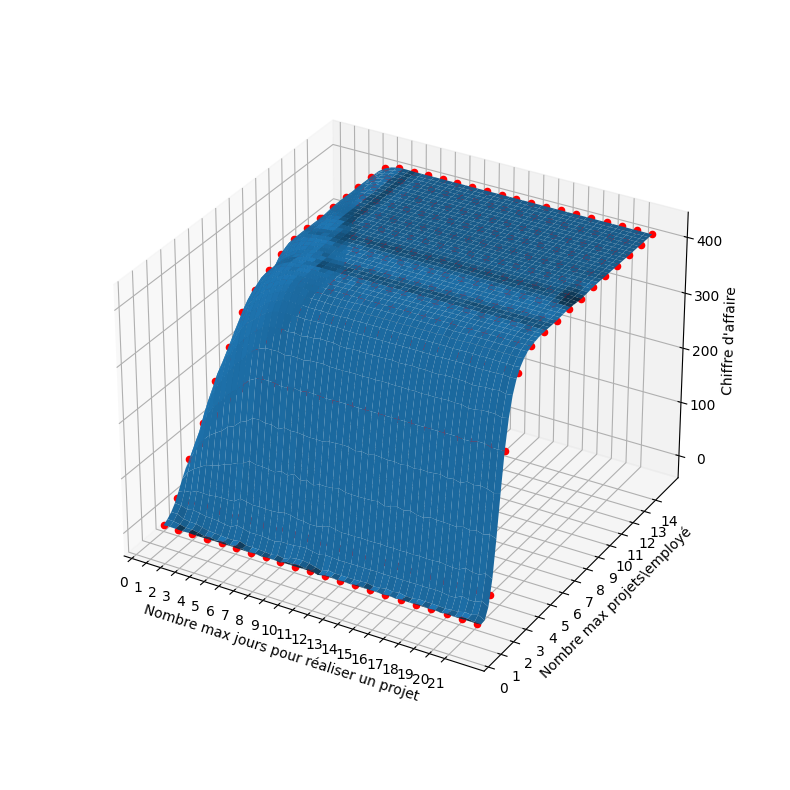

In [9]:
points = results

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))

X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

for point in results:
    xi, yi, zi = point
    ax.scatter(xi, yi, zi, c='r', marker='o')

ax.set_xlabel('Nombre max jours pour réaliser un projet')
ax.set_xticks(np.arange(int(max(x))))
ax.set_ylabel('Nombre max projets\\employé')
ax.set_yticks(np.arange(int(max(y))))
ax.set_zlabel('Chiffre d\'affaire')
ax.dist = 12
plt.show()


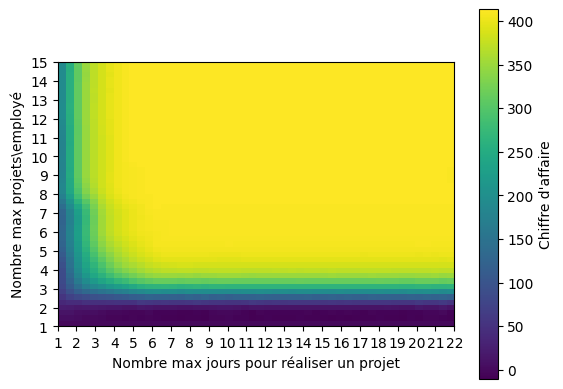

In [10]:
import numpy as np
import matplotlib.pyplot as plt

points = results
x = np.array([point[0] for point in points])
y = np.array([point[1] for point in points])
z = np.array([point[2] for point in points])
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Chiffre d\'affaire')
plt.xlabel('Nombre max jours pour réaliser un projet')
plt.xticks(np.arange(1, int(max(x) + 1)))
plt.ylabel('Nombre max projets\\employé')
plt.yticks(np.arange(1, int(max(y) + 1)))
plt.show()

### Catégorisation des solutions

In [11]:
# Implémentation Python
num_edt, dim = results.shape

m = Model("Preferences")
# W : Dict[int, Var]
W = {d: m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'w{d}') for d in range(dim)}

d_plus = []
d_moins = []
for j in range(num_edt):
    d_plus.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'd_plus_{j}'))
    d_moins.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'd_moins_{j}'))

# EdtDictLinExpr : Dict[int, LinExpr]
EdtDictLinExpr = {
    j: quicksum([W[i] * results[j][i] for i in range(dim)]) / max(results[j]) - d_plus[
        j] + d_moins[j] for j in range(num_edt)}

# Contraintes inacceptables
m.addConstr(EdtDictLinExpr[0] <= 1 / 3, name="C_1")
m.addConstr(EdtDictLinExpr[1] <= 1 / 3, name="C_2")
m.addConstr(EdtDictLinExpr[30] <= 1 / 3, name="C_3")
m.addConstr(EdtDictLinExpr[31] <= 1 / 3, name="C_4")
m.addConstr(EdtDictLinExpr[328] <= 1 / 3, name="C_5")
m.addConstr(EdtDictLinExpr[329] <= 1 / 3, name="C_6")

# Contraintes correctes
m.addConstr(EdtDictLinExpr[127] <= 2 / 3, name="C_7")
m.addConstr(EdtDictLinExpr[127] >= 1 / 3, name="C_8")
m.addConstr(EdtDictLinExpr[171] <= 2 / 3, name="C_9")
m.addConstr(EdtDictLinExpr[171] >= 1 / 3, name="C_10")
m.addConstr(EdtDictLinExpr[291] <= 2 / 3, name="C_11")
m.addConstr(EdtDictLinExpr[291] >= 1 / 3, name="C_12")

# Contraintes satisfaisantes
m.addConstr(EdtDictLinExpr[232] >= 2 / 3, name="C_13")
m.addConstr(EdtDictLinExpr[260] >= 2 / 3, name="C_14")
m.addConstr(EdtDictLinExpr[264] >= 2 / 3, name="C_15")

# Contrainte 4 : Normalisation
m.addConstr(quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0  # mode muet

# -- Mise à jour du modèle  --
m.update()

m.setObjective(quicksum(d_plus[j] + d_moins[j] for j in range(num_edt)), GRB.MAXIMIZE)

m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Infasible")
if m.status == GRB.UNBOUNDED:
    print("Unbounded")
if m.status == GRB.OPTIMAL:
    weights = [W[i].x for i in range(dim)]
    print("Optimal")
    print(weights)

scores = [EdtDictLinExpr[j].getValue() for j in range(num_edt)]
results_pd['score'] = scores
results_pd['status'] = results_pd['score'].apply(
    lambda x: 'Inacceptable' if x < 1 / 3 else (
        'Correcte' if x < 2 / 3 else 'Satisfaisante'))
results_pd

Optimal
[0.0, 0.6798353909465021, 0.32016460905349786]


,Day,NbProject,Price,score,status
0,22.0,15.0,413.0,0.333333,Inacceptable
1,22.0,14.0,413.0,0.333333,Inacceptable
2,22.0,13.0,413.0,0.341564,Correcte
3,22.0,12.0,413.0,0.339918,Correcte
4,22.0,11.0,413.0,0.338272,Correcte
...,...,...,...,...,...
325,1.0,5.0,120.0,0.348491,Correcte
326,1.0,4.0,90.0,0.350380,Correcte
327,1.0,3.0,80.0,0.345658,Correcte
328,1.0,2.0,30.0,0.333333,Correcte


## Large dataset

### Import des données

In [12]:
with open("../solutions/large/solutions.json") as f:
    data = json.load(f)

In [13]:
results = []
for key1 in data:
    for key2 in data[key1]:
        results.append([int(key1), int(key2), data[key1][key2]])
results = np.array(results)
results_pd = pd.DataFrame({
    "Day": results[:, 0],
    "NbProject": results[:, 1],
    "Price": results[:, 2]
})
results_pd

,Day,NbProject,Price
0,37.0,25.0,817.0
1,37.0,24.0,817.0
2,37.0,23.0,817.0
3,37.0,22.0,817.0
4,37.0,21.0,817.0
...,...,...,...
920,1.0,5.0,140.0
921,1.0,4.0,140.0
922,1.0,3.0,90.0
923,1.0,2.0,60.0


### Visualisations

/var/folders/5q/nhw4d0ys1kqgclnb7dz1yphm0000gp/T/ipykernel_89478/3086265837.py:26: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


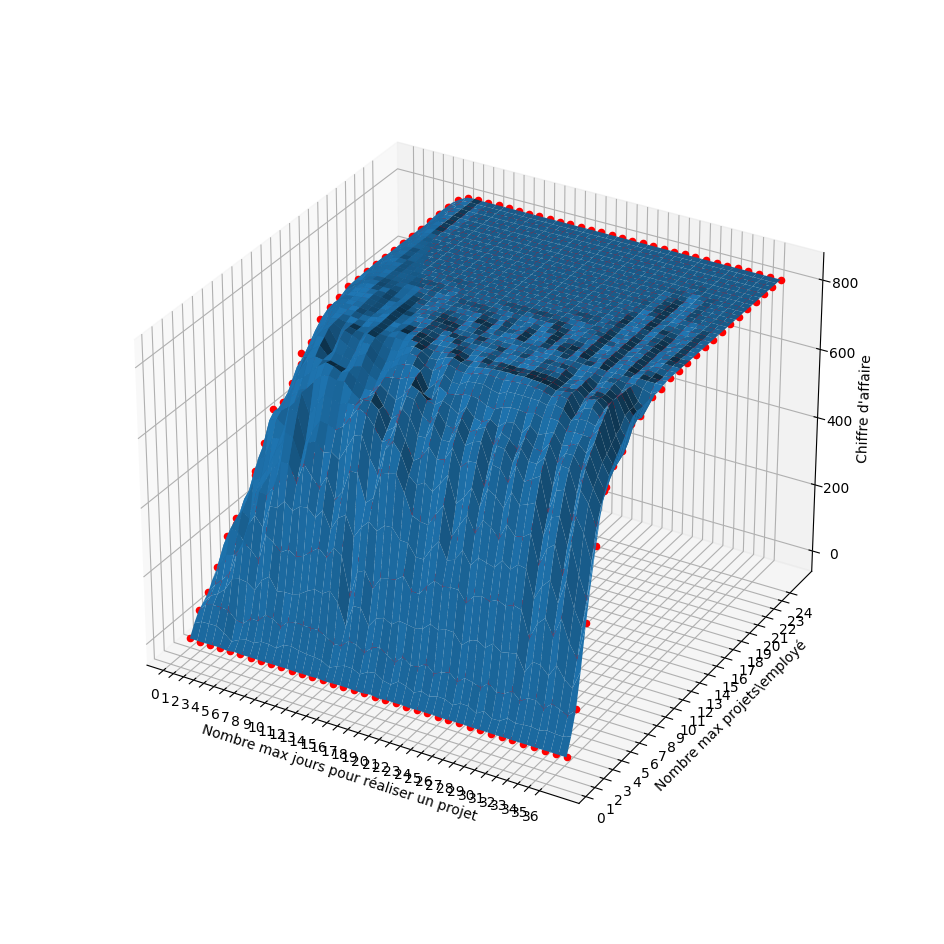

In [14]:
points = results

x = [point[0] for point in points]
y = [point[1] for point in points]
z = [point[2] for point in points]

xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))

X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

for point in results:
    xi, yi, zi = point
    ax.scatter(xi, yi, zi, c='r', marker='o')

ax.set_xlabel('Nombre max jours pour réaliser un projet')
ax.set_xticks(np.arange(int(max(x))))
ax.set_ylabel('Nombre max projets\\employé')
ax.set_yticks(np.arange(int(max(y))))
ax.set_zlabel('Chiffre d\'affaire')
ax.dist = 12
plt.show()

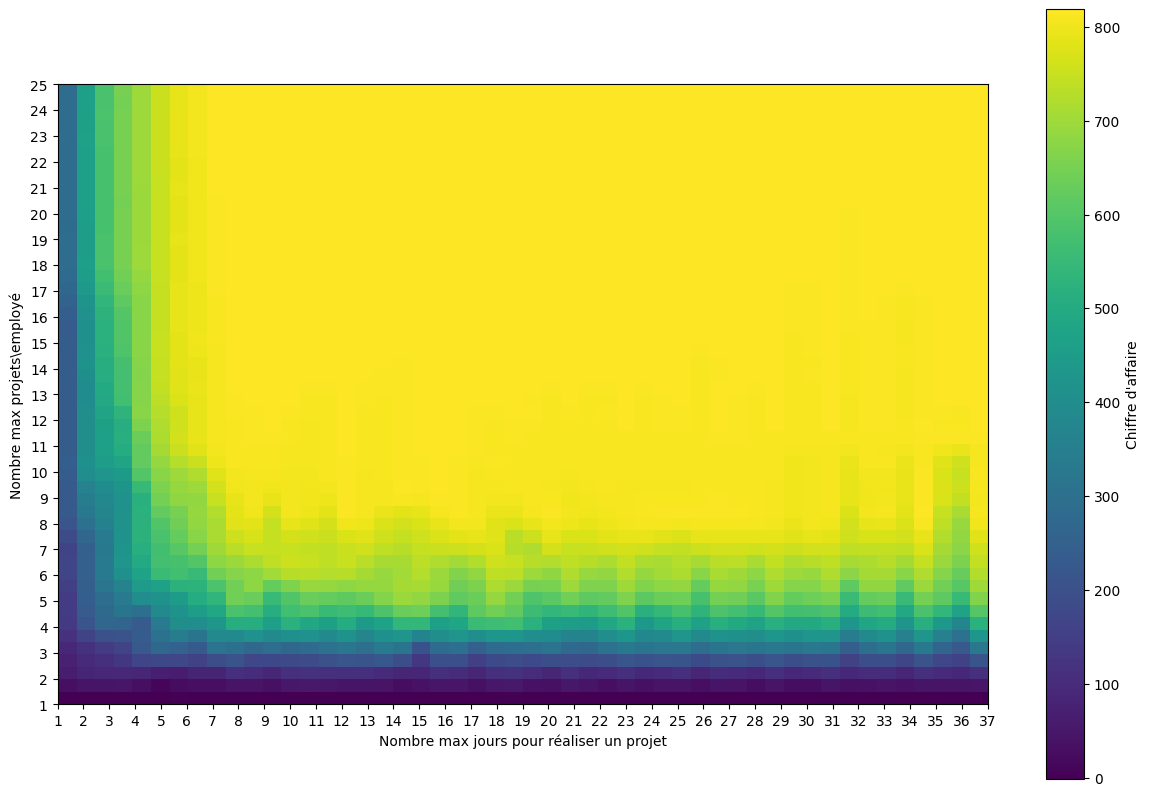

In [15]:
import numpy as np
import matplotlib.pyplot as plt

points = results
x = np.array([point[0] for point in points])
y = np.array([point[1] for point in points])
z = np.array([point[2] for point in points])
xi = np.linspace(min(x), max(x))
yi = np.linspace(min(y), max(y))
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), z, (X, Y), method='cubic')

plt.figure(figsize=(15, 10))
plt.imshow(Z, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Chiffre d\'affaire')
plt.xlabel('Nombre max jours pour réaliser un projet')
plt.xticks(np.arange(1, int(max(x) + 1)))
plt.ylabel('Nombre max projets\\employé')
plt.yticks(np.arange(1, int(max(y) + 1)))
plt.show()

### Catégorisation des solutions

In [16]:
# Implémentation Python
num_edt, dim = results.shape

m = Model("Preferences")
# W : Dict[int, Var]
W = {d: m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'w{d}') for d in range(dim)}

d_plus = []
d_moins = []
for j in range(num_edt):
    d_plus.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'd_plus_{j}'))
    d_moins.append(m.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=1, name=f'd_moins_{j}'))

# EdtDictLinExpr : Dict[int, LinExpr]
EdtDictLinExpr = {
    j: quicksum([W[i] * results[j][i] for i in range(dim)]) / max(results[j]) - d_plus[
        j] + d_moins[j] for j in range(num_edt)}

# Contraintes inacceptables
m.addConstr(EdtDictLinExpr[1] <= 1 / 3, name="C_1")
m.addConstr(EdtDictLinExpr[18] <= 1 / 3, name="C_2")
m.addConstr(EdtDictLinExpr[427] <= 1 / 3, name="C_3")
m.addConstr(EdtDictLinExpr[551] <= 1 / 3, name="C_4")

# Contraintes correctes
m.addConstr(EdtDictLinExpr[493] <= 2 / 3, name="C_5")
m.addConstr(EdtDictLinExpr[493] >= 1 / 3, name="C_6")
m.addConstr(EdtDictLinExpr[516] <= 2 / 3, name="C_7")
m.addConstr(EdtDictLinExpr[516] >= 1 / 3, name="C_8")
m.addConstr(EdtDictLinExpr[552] <= 2 / 3, name="C_9")
m.addConstr(EdtDictLinExpr[552] >= 1 / 3, name="C_10")

# Contraintes satisfaisantes
m.addConstr(EdtDictLinExpr[688] >= 2 / 3, name="C_11")
m.addConstr(EdtDictLinExpr[689] >= 2 / 3, name="C_12")
m.addConstr(EdtDictLinExpr[756] >= 2 / 3, name="C_13")

# Contrainte 4 : Normalisation
m.addConstr(quicksum(W.values()) == 1., name="Normalisation")

# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0  # mode muet

# -- Mise à jour du modèle  --
m.update()

m.setObjective(quicksum(d_plus[j] + d_moins[j] for j in range(num_edt)), GRB.MAXIMIZE)

m.optimize()
if m.status == GRB.INFEASIBLE:
    print("Infasible")
if m.status == GRB.UNBOUNDED:
    print("Unbounded")
if m.status == GRB.OPTIMAL:
    weights = [W[i].x for i in range(dim)]
    print("Optimal")
    print(weights)

scores = [EdtDictLinExpr[j].getValue() for j in range(num_edt)]
results_pd['score'] = scores
results_pd['status'] = results_pd['score'].apply(
    lambda x: 'Inacceptable' if x < 1 / 3 else (
        'Correcte' if x < 2 / 3 else 'Satisfaisante'))
results_pd

Optimal
[0.0, 0.6727589208006963, 0.3272410791993037]


,Day,NbProject,Price,score,status
0,37.0,25.0,817.0,0.347827,Correcte
1,37.0,24.0,817.0,0.333333,Inacceptable
2,37.0,23.0,817.0,0.346180,Correcte
3,37.0,22.0,817.0,0.345357,Correcte
4,37.0,21.0,817.0,0.344534,Correcte
...,...,...,...,...,...
920,1.0,5.0,140.0,0.351268,Correcte
921,1.0,4.0,140.0,0.346463,Correcte
922,1.0,3.0,90.0,0.349666,Correcte
923,1.0,2.0,60.0,0.349666,Correcte
